## For Colabs

In [1]:
from getpass import getpass
import os

user = "OliverJBoom"
password = "Ym100%otsydt"
# password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 500 (delta 32), reused 30 (delta 14), pack-reused 446
Receiving objects: 100% (500/500), 6.48 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (270/270), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [108]:
from copy import deepcopy
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [109]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")
use_lg_returns = False

## Preprocessing

In [111]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
  # Lg Returns Only
  df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
  target_col = "cu_lme"
  
else:
  # Price Only
  df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
  target_col = "price_cu_lme"

# Set to False initially
PCA_used = False

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  

In [0]:
# Visualise the plots
# visualise_universe(universe_dict)

In [113]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


### Normalizing the dataset

In [0]:
# Forecast length
forecast_length = 5

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = shift(data_y.ravel(), -forecast_length)[:-forecast_length]
# Check shape assert(data_X.shape[:, 0]== data_y.shape[0])

### PCA

In [115]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

Number of dimensions: 6
Explained Variance: [0.49030338 0.23270694 0.1439148  0.04789975 0.02769706 0.0219951 ] 
Explained Variance Sum: 0.9645170286882985


### Slicing Series into Windows

In [0]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.1)

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

n_epochs = 5

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1

### Initialising the model

In [118]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 1 
num_layers 2
data_X  (82, 250, 6) 
data_y (82,)


In [119]:
# Loading trained model
model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "LSTM_0_040.pth")
model.to(device)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, dropout=0.1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (act): ReLU()
  (out): Linear(in_features=128, out_features=1, bias=True)
)

saving model 0.024320756687837487
best model score 0.024320756687837487
inf
Count: 0
Epoch: 0 Train MSE: 0.06375 Val MSE: 0.02432  Time: 2.387


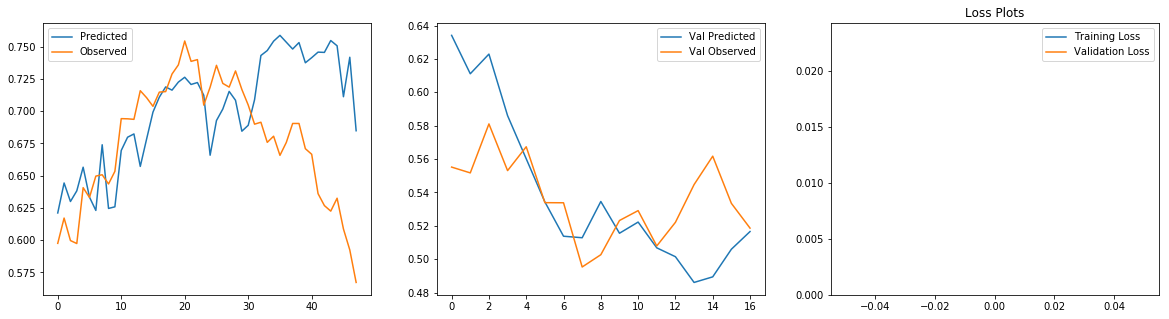

best model score 0.024320756687837487
0.024320756687837487
Count: 1
Epoch: 1 Train MSE: 0.02616 Val MSE: 0.03603  Time: 5.579
best model score 0.024320756687837487
0.024320756687837487
Count: 2
Epoch: 2 Train MSE: 0.05799 Val MSE: 0.04117  Time: 8.244
best model score 0.024320756687837487
0.024320756687837487
Count: 3
Epoch: 3 Train MSE: 0.06499 Val MSE: 0.02977  Time: 10.977
saving model 0.02055048942565918
best model score 0.02055048942565918
0.024320756687837487
Count: 0
Epoch: 4 Train MSE: 0.03934 Val MSE: 0.02055  Time: 13.714
saving model 0.01741785161635455
best model score 0.01741785161635455
0.02055048942565918
Count: 0
Epoch: 5 Train MSE: 0.02692 Val MSE: 0.01742  Time: 16.441
saving model 0.01666558665387771
best model score 0.01666558665387771
0.01741785161635455
Count: 0
Epoch: 6 Train MSE: 0.02615 Val MSE: 0.01667  Time: 19.219
best model score 0.01666558665387771
0.01666558665387771
Count: 1
Epoch: 7 Train MSE: 0.02178 Val MSE: 0.01830  Time: 21.955
best model score 0.01

In [125]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=10,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=1,
                        fig_disp_freq=10, 
                        device=device,
                        patience=100)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [126]:
learning.best_val_score

0.01666558665387771

In [127]:
print(learning.logs["Validation Loss"])
print(learning.best_val_score)

[0.024320756687837487, 0.03603248035206514, 0.04117278491749483, 0.02976700838874368, 0.02055048942565918, 0.01741785161635455, 0.01666558665387771, 0.018300272086087394, 0.022471252609701717, 0.024590190719155705]
0.01666558665387771


In [129]:
# learning.create_data_loaders()
print(learning.validate(learning.val_loader))
print(learning.evaluate(learning.best_model, learning.val_loader))

0.024590190719155705
0.01666558665387771


In [0]:
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'wb'))

In [0]:
learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [0]:
model_save(model_lstm, 
           path="/content/gdrive/My Drive/Chai/Models/Pths",
           name="LSTM_Full", 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

### Plotting

In [0]:
# Rescaling Example

scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1))
plt.plot(scaler_data_y.inverse_transform(learning_load.y_train.numpy().reshape(-1, 1)))
plt.plot(scaler_data_y.inverse_transform(np.array(learning_load.train_predictions).reshape(-1, 1)))
plt.show()

In [0]:
predicted_train = learning.train_predictions
observed_train = learning.y_train.numpy()

learning.model = learning.best_model
learning.validate(learning.val_loader)
predicted_val = learning.val_predictions
observed_val = learning.y_val.numpy()

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].set_title("Predicted vs Observed Values")
ax[0].plot(predicted_train, label="Predicted")
ax[0].plot(observed_train, label="Observed")
ax[0].legend()

ax[1].set_title("Predicted vs Observed Values")
ax[1].plot(predicted_val, label="Predicted")
ax[1].plot(observed_val, label="Observed")
ax[1].legend()
           
ax[2].set_title("Loss Plots")
ax[2].plot(learning.logs['Training Loss'], label="Training Loss")
ax[2].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[2].legend()
ax[2].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"

plt.savefig(path + str("LSTM_Val_" + str(val_score)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))
plt.show()

In [0]:
plt.title("Predicted vs Observed Values")
plt.plot(learning.test_predictions, label="Predicted")
plt.plot(learning.y_test.numpy(), label="Observed")
plt.legend()

In [0]:
# The minimum validation loss
val_loss = min(learning.logs['Validation Loss'])
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [0]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          "Full_Run",
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          path="/content/gdrive/My Drive/Chai/Models/") 

# Results

In [0]:
mse, mae, mde = evaluate(learning.test_predictions, learning.y_test.numpy())
print(mse, mae, mde)

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()